In [1]:
import numpy as np              # numpy is a general-purpose math package
import yt                       # yt is the data vizualization package
from yt.units import *          # this lets you get things like speed of light in proper units just by typing 'c'
from astropy.table import Table # this is needed for reading in various foggie data byproducts
from astropy.io import ascii    # this too
import matplotlib.pyplot as plt # this is the standard python plotting package, very useful!
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import math
from ipynb.fs.defs.FRB_and_Projection_functions import frb_projection, projection
from scipy import optimize
import pwlf # A library for fitting continuous piecewise linear functions to data (Returns cut-off radius)
import os #for the lacie part 

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.foggie_load import *

home_dir = '/Users/hylee/foggie/'
laptop_root_dir = home_dir + 'foggie_sims/' # root directory where sims are stored on the laptop
hd_root_dir = '/Volumes/LaCie/' # root directory where sims are stored on the hard drive

root_dir = hd_root_dir # have this as either laptop_root_dir or hd_root_dir depending on where the simulation is stored
code_path = '/Users/hylee/coding/foggie/foggie/' #path to the cloned github repo

# everything above this is general path, and below this is specific to a given halo
halo = '8508' # which halo
simulation_dir = root_dir + 'halo_00' + halo + '/nref11c_nref9f/' # path where the foggie simulations are stored
output_dir = home_dir + 'foggie_output/halo_00' + halo + '/nref11c_nref9f/' # path where all the outputs will be stored
track_dir = code_path + 'halo_infos/00' + halo + '/nref11c_nref9f/'
track_name = code_path + 'halo_tracks/00' + halo + '/nref11n_selfshield_15/halo_track_200kpc_nref9' #these need to be provided to foggie_load()

In [2]:
def radius_func(od, size, res):
    OD_Qua=[]
    OD_Rad=[]  #OD_Rad & OD_Met HAVE to be defined specifically inside func1/before for loop
    for i in range(70):
        for j in range(70):
            this_quantity_value = od[i][j]
            xindex = i
            yindex = j
            radius = (math.sqrt(((yindex-34)**2+(xindex-34)**2)))*(size/res)
            OD_Qua.append(this_quantity_value)
            OD_Rad.append(radius)
    return OD_Rad, OD_Qua

In [3]:
def binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize):
    index = 0 
    quantitylist = []
    sort = np.argsort(OD_Rad)
    sorted_radius = np.array(OD_Rad)[sort]
    sorted_quantity = np.array(OD_Qua)[sort]
    radiuslist = np.arange(min_radius, max_radius, binsize) + binsize/2
    while index < len(radiuslist):
        left_edge = index*binsize
        right_edge = left_edge + binsize 
        new_quantity = np.array(sorted_quantity)[(left_edge <= sorted_radius) & (sorted_radius < right_edge)]
        quantitylist.append((np.mean(new_quantity)))
        index +=1
    return radiuslist, quantitylist

In [4]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

In [20]:
def plotting(xvalue, yvalue_origdata, yvalue_cutoff, color_original, color_cutoff, plotlabel_linedot,
            plotlabel_segment, fig):
    #fig1 = plt.figure()
    plt.plot(xvalue, yvalue_origdata, color_original, label=plotlabel_linedot)
    plt.plot(xvalue, yvalue_cutoff, color_cutoff, label=plotlabel_segment)
    #plt.plot(xvalue, piecewise_linear(new_radius, *p0), 'g')
    plt.legend(loc="upper right", fontsize = 15)
    plt.xlabel("Radius from galactic center [kpc]", fontsize = fontsize)
    plt.ylabel("Density [log 10 g/cm^2]", fontsize = fontsize)
    plt.xticks(fontsize = fontsize/1.5)
    plt.yticks(fontsize = fontsize/1.5)
    #return fig1

In [6]:
DDLIST = []
for file in os.listdir(simulation_dir):
    if file.startswith("DD"):
        DDLIST.append(file)
sorted_dd_list = sorted(DDLIST, key=lambda x: int(x[2:]))

In [7]:
sorted_dd_list

['DD0138',
 'DD0238',
 'DD0287',
 'DD0293',
 'DD0338',
 'DD0438',
 'DD0538',
 'DD0638',
 'DD0738',
 'DD0838',
 'DD0938',
 'DD1038',
 'DD1138',
 'DD1238',
 'DD1338',
 'DD1438',
 'DD1477',
 'DD1478',
 'DD1479',
 'DD1538',
 'DD1638',
 'DD1738',
 'DD1838',
 'DD1938',
 'DD2038',
 'DD2138',
 'DD2238',
 'DD2288',
 'DD2289',
 'DD2338',
 'DD2427']

In [8]:
redshiftlist = []
cutofflist = []
timelist = []
    
snap = "DD1238" # name of the snapshot output
snap_fullpath = simulation_dir + snap + '/' + snap # full path of where the snapshot output lives
field = "density"
axis_x = "x"
axis_y = "y"
axis_z = "z"
resolution = 70 #[pixel]
quantitylabel = 'Density [log 10 g/cm^2]'
min_radius = 0  #[kpc]
markersize = 10
fontsize = 15 
plotlabel_linedot = 'Binned mean density'
plotlabel_segment = 'Fitted density of' + " " + snap

In [9]:
ds, refine_box = foggie_load(snap_fullpath, track_name, halo_c_v_name=track_dir + 'halo_c_v',
                                  disk_relative=False, do_filter_particles=False, masses_dir=track_dir)
        
z = ds.get_parameter("CosmologyCurrentRedshift")
current_time = ds.current_time.in_units('Gyr').value


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1238/DD1238


yt : [INFO     ] 2023-07-31 23:02:03,725 Parameters: current_time              = 342.31652781829
yt : [INFO     ] 2023-07-31 23:02:03,726 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-31 23:02:03,726 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-31 23:02:03,727 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-31 23:02:03,728 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-31 23:02:03,729 Parameters: current_redshift          = 0.70104740107777
yt : [INFO     ] 2023-07-31 23:02:03,730 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-31 23:02:03,730 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-31 23:02:03,731 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-31 23:02:03,732 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2    col3     col4     col5    col6     col7   col8
---------------- ------- -------- -------- ------- -------- -------- ----
0.70104740107777 0.49091 0.479176 0.504679 0.49291 0.481176 0.506679    9


Parsing Hierarchy : 100%|█████████████████| 6009/6009 [00:00<00:00, 8184.16it/s]
yt : [INFO     ] 2023-07-31 23:02:04,784 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


In [10]:
#variable = ds.all_data()

In [11]:
#proj = yt.ProjectionPlot(ds, "x", "density", center=ds.halo_center_kpc, width=(20., 'kpc'), data_source=refine_box,
                       #  weight_field="density")

In [12]:
width = 200/(1+z) #[kpc]
max_radius = width/2 #[kpc]
binsize = 3/(z+1) #[kpc]

In [13]:
frb_x = frb_projection(ds, field, axis_x, refine_box, width, resolution, weight_field = None)
frb_y = frb_projection(ds, field, axis_y, refine_box, width, resolution, weight_field = None)
frb_z = frb_projection(ds, field, axis_z, refine_box, width, resolution, weight_field = None)

yt : [INFO     ] 2023-07-31 23:03:21,692 Projection completed


In [14]:
OD_Rad_x, OD_Qua_x = radius_func(np.array(frb_x["gas",field]), width, resolution)
OD_Rad_y, OD_Qua_y = radius_func(np.array(frb_y["gas",field]), width, resolution)
OD_Rad_z, OD_Qua_z = radius_func(np.array(frb_z["gas",field]), width, resolution)

yt : [INFO     ] 2023-07-31 23:03:28,111 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


In [15]:
radiuslist_x, quantitylist_x =  binning_func(OD_Rad_x, OD_Qua_x, max_radius, min_radius, binsize)
radiuslist_y, quantitylist_y =  binning_func(OD_Rad_y, OD_Qua_y, max_radius, min_radius, binsize)
radiuslist_z, quantitylist_z =  binning_func(OD_Rad_z, OD_Qua_z, max_radius, min_radius, binsize)

In [16]:
new_radius_x = np.ma.compressed(np.ma.masked_where(np.isnan(quantitylist_x), radiuslist_x))
new_quantity_x  = np.ma.compressed(np.ma.masked_where(np.isnan(quantitylist_x), quantitylist_x))
new_radius_y = np.ma.compressed(np.ma.masked_where(np.isnan(quantitylist_y), radiuslist_y))
new_quantity_y  = np.ma.compressed(np.ma.masked_where(np.isnan(quantitylist_y), quantitylist_y))
new_radius_z = np.ma.compressed(np.ma.masked_where(np.isnan(quantitylist_z), radiuslist_z))
new_quantity_z  = np.ma.compressed(np.ma.masked_where(np.isnan(quantitylist_z), quantitylist_z))

In [17]:
p_x , e_x = optimize.curve_fit(piecewise_linear, new_radius_x, np.log10(new_quantity_x), p0 = [20,4,-0.1,-0.05])
p_y , e_y = optimize.curve_fit(piecewise_linear, new_radius_y, np.log10(new_quantity_y), p0 = [20,4,-0.1,-0.05])
p_z , e_z = optimize.curve_fit(piecewise_linear, new_radius_z, np.log10(new_quantity_z), p0 = [20,4,-0.1,-0.05])

In [18]:
fig = plt.figure()

<Figure size 640x480 with 0 Axes>

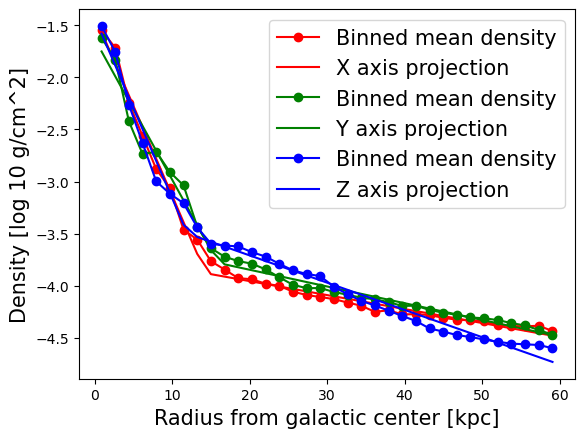

In [22]:
segment_plot_x = plotting(new_radius_x, np.log10(new_quantity_x), piecewise_linear(new_radius_x, *p_x),
                        'ro-','r-', plotlabel_linedot, "X axis projection", fig)
segment_plot_y = plotting(new_radius_y, np.log10(new_quantity_y), piecewise_linear(new_radius_y, *p_y),
                        'go-','g-', plotlabel_linedot, "Y axis projection", fig)
segment_plot_z = plotting(new_radius_z, np.log10(new_quantity_z), piecewise_linear(new_radius_z, *p_z),
                        'bo-','b-', plotlabel_linedot, "Z axis projection", fig)



#projection_plot.savefig(output_dir + snap + "_Density_Projection_Plot.jpg")



In [ ]:
'''
proj = yt.ProjectionPlot(ds, "y", ('gas', 'density'), center=ds.halo_center_kpc, width=(200., 'kpc'), data_source=refine_box)
proj.set_unit('density', 'Msun/pc**2')           # change the units of the density to solar masses per square parsec
proj.set_cmap('density', density_color_map)      # change the color map used
proj.set_zlim('density', density_proj_min, density_proj_max)
'''

In [ ]:
ds.current_time.in_units('Gyr').value+0

In [ ]:

# We can plot the gas density in the simulation using yt's ProjectionPlot function:
proj = yt.ProjectionPlot(ds, "y", ('gas', 'density'), center=ds.halo_center_kpc, width=(100., 'kpc'), data_source=refine_box)
# This tells yt to make a projection of the field "density" in the x-direction, using the dataset 'ds',
# centered on 'ds.halo_center_kpc', with a width of the view window of 200 kiloparsecs, and to restrict
# what's plotted to only the subset of the dataset in 'refine_box'. 'ds.halo_center_kpc' is a variable
# that gives the location of the center of the galaxy. The whole simulation dataset is enormous,
# so you'll need that to find where the galaxy is to plot it! Try changing "x" to "y" or "z"
# instead to see the galaxy from different angles. Try changing the width from 200 to 100 or 50 to zoom in.

# With the projection plot made, we can now modify some things that will be useful to know.
proj.set_unit('density', 'Msun/pc**2')           # change the units of the density to solar masses per square parsec
proj.set_cmap('density', density_color_map)      # change the color map used
proj.set_zlim('density', density_proj_min, density_proj_max)

In [ ]:
proj.save(output_dir + snap + '/' +snap +'density_forslide.png')
